## 1. Setup and Configuration

### 1.1 Installing Necessary Libraries

In [ ]:
!pip install opencv-python torch torchvision
!pip install torch-enhance
!pip install basicsr

### 1.2 Importing Libraries

In [175]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Normalize, Resize, Compose, ToPILImage
from torch import nn, optim
import torch.nn.functional as F
import cv2
from d2l import torch as d2l
import argparse
import glob
from basicsr.archs.rrdbnet_arch import RRDBNet
import shutil
import random
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import classification_report, confusion_matrix

## 2. Data Loading and Initial Processing

#### [Brain Tumor Classification (MRI)](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/data)

**Abstract:**
A Brain tumor is considered as one of the aggressive diseases, among children and adults. Brain tumors account for 85 to 90 percent of all primary Central Nervous System(CNS) tumors. Every year, around 11,700 people are diagnosed with a brain tumor. The 5-year survival rate for people with a cancerous brain or CNS tumor is approximately 34 percent for men and36 percent for women. Brain Tumors are classified as: Benign Tumor, Malignant Tumor, Pituitary Tumor, etc. Proper treatment, planning, and accurate diagnostics should be implemented to improve the life expectancy of the patients. The best technique to detect brain tumors is Magnetic Resonance Imaging (MRI). A huge amount of image data is generated through the scans. These images are examined by the radiologist. A manual examination can be error-prone due to the level of complexities involved in brain tumors and their properties.

**About this directory**: The folder contains MRI data. The images are already split into Training and Testing folders. Each folder has more four subfolders. These folders have MRIs of respective tumor classes.

**Acknowledgements for Dataset:**
Sartaj Bhuvaji, Ankita Kadam, Prajakta Bhumkar, Sameer Dedge, and Swati Kanchan. (2020). Brain Tumor Classification (MRI) [Data set]. Kaggle.

![https://unsplash.com/photos/white-and-brown-flower-petals-Jt72_opb38I](expalin_Images/mini_brains.jpg)

### 2.1 Loading the Dataset
- Initial Data Cleaning (Duplicate Elimination)

In [11]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

X_train = []
Y_train = []
image_hashes = set() # image hash to detect duplicates

desired_size = (150, 150)

for split in ['Training', 'Testing']:
    for label in labels:
        folder_path = os.path.join('data/', split, label)
        
        images = os.listdir(folder_path)
        for image_name in images:
            if image_name.startswith('.'):
                # Skip non images files and directories (hidden directories)
                continue
            image_path = os.path.join(folder_path, image_name)
            with Image.open(image_path) as img:
                img = img.resize(desired_size)
                img_array = np.array(img) 
                
                # Create a hash of the processed image
                hash_val = hash(img_array.tobytes())
                
                # Check if this hash is already in the set
                if hash_val not in image_hashes:
                    image_hashes.add(hash_val)
                    X_train.append(img_array)
                    Y_train.append(label)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

# randomized data
np.random.seed(1)
indices = np.random.permutation(len(X_train))

X_train = X_train[indices]
Y_train = Y_train[indices]

print(X_train.shape, Y_train.shape)

(2870, 150, 150, 3) (2870,)


### 2.2 Basic Data Visualizations

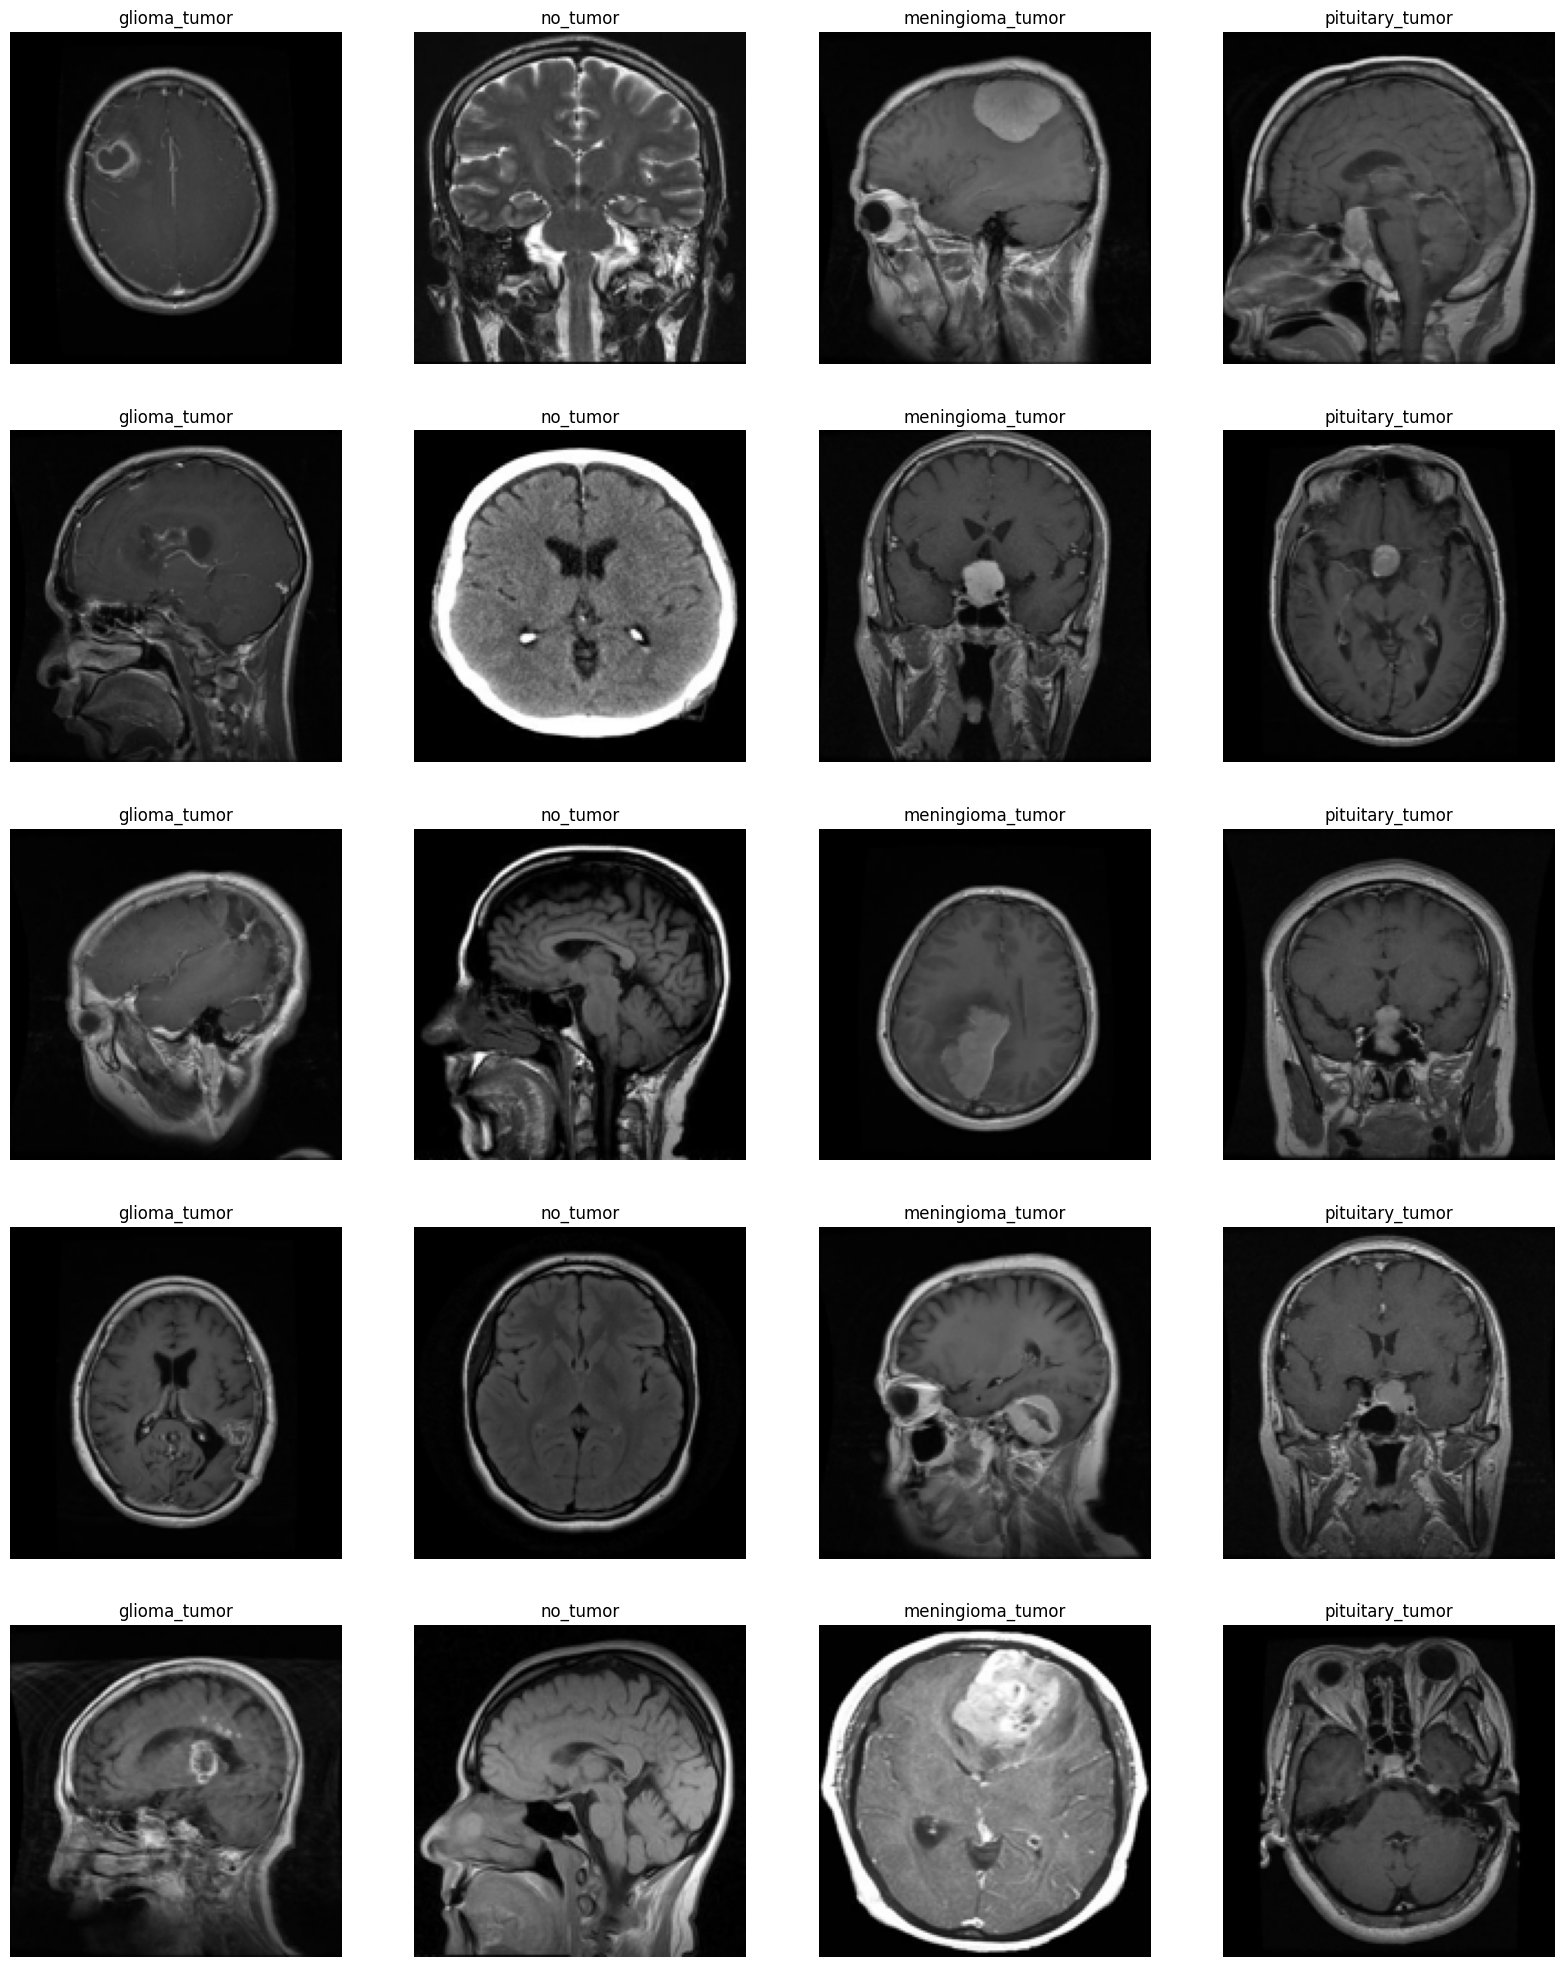

In [12]:
def showImg(X_train, Y_train, labels, num=1):
    '''
    This function plots images for each class label. If the desired number of images for each label is 5,
    this function will try to look for the first  five occurrence of the labels. 
    
    Parameters:
    - X_train: images
    - Y_train: labels of the images
    - labels: a list that contain the labels of the images
    
    Returns:
    None: This function does not return a value, it makes a plot of images. 
    '''
    label_to_image = {}

    for img, label in zip(X_train, Y_train):
        # Store the first occurrence of each label
        if label not in label_to_image:
            label_to_image[label] = [img]
        elif len(label_to_image[label]) < num:
            label_to_image[label].append(img)

        if len(label_to_image.keys()) == len(labels):
            # Check if we have enough images for each label
            all_full = all(len(images) == num for images in label_to_image.values())
            if all_full:
                break

    # Determine the number of labels and set up the subplot dimensions
    num_labels = len(labels)
    fig, axes = plt.subplots(num, num_labels, figsize=(20, 5 * num)) 
    axes = axes.flatten()

    for j in range(num):
        for i, label in enumerate(labels):
            index = i + j * num_labels  # Calculate the correct index in the flattened array
            if j < len(label_to_image[label]):  # Check if there is an image to show
                axes[index].imshow(label_to_image[label][j])
                axes[index].axis('off')  # Hide axes
                axes[index].set_title(label)
            else:
                axes[index].axis('off')  # Hide axes if no image is available

    plt.show()
    
showImg(X_train, Y_train, labels, num=5)

## 3. Data Preparation and Enhancement

![https://unsplash.com/photos/human-brain-toy-IHfOpAzzjHM](expalin_Images/brain_neuron.jpg)

### 3.1 Applying Image Transformations

Enhancing Image Quality with Super Resolution Model: 
- **Super Resolution BasicSR ESRGAN**: https://github.com/XPixelGroup/BasicSR

**Acknowledgements for BasicSR ESRGAN:**
Xintao Wang, Liangbin Xie, Ke Yu, Kelvin C.K. Chan, Chen Change Loy and Chao Dong. BasicSR: Open Source Image and Video Restoration Toolbox. https://github.com/xinntao/BasicSR, 2022.

In [65]:
def random_rotation(img):
    '''
    rotates an iamge ramdonly between -5 to 5 degrees
    
    Parameters: 
    - img: image
    
    Returns:
    image: Transformed image
    '''
    angle = np.random.randint(-5, 5)  
    rows, cols = img.shape[0:2]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    return cv2.warpAffine(img, M, (cols, rows))

def horizontal_flip(img):
    '''
    Flip the image along y-axis
    
    Parameters: 
    - img: image
    
    Returns:
    image: Transformed image
    '''
    return cv2.flip(img, 1)  

def apply_clahe(img):
    '''
    This function applies Contrast Limited Adaptive Histogram Equalization (CLAHE) which it is an advanced 
    form of histogram equalization that is used in image processing to enhance the contrast of images.
    
    Parameters: 
    - img: image
    
    Returns:
    image: Transformed image
    '''
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img_gray)

def apply_laplacian(img):
    '''
    This function applies Laplacian a mathematical operator widely used for edge detection.
    
    Parameters: 
    - img: image
    
    Returns:
    image: Transformed image
    '''
    laplacian = cv2.Laplacian(img, cv2.CV_64F)
    return cv2.convertScaleAbs(laplacian)

def histogram_equalization(img):
    '''
    This function applies Histogram Equalization is use to enhance the contrast of images. It is 
    particularly effective in improving the visibility of foreground objects in images that suffer 
    from background illumination or where the contrast is otherwise poor.
    
    Parameters: 
    - img: image
    
    Returns:
    image: Transformed image
    '''
    return cv2.equalizeHist(img)

def apply_gaussian_blur(img, kernel_size=(5, 5), sigma=0):
    '''
    This function applies Gaussian blur, also known as Gaussian smoothing, is a widely used effect in 
    image processing that helps in reducing image noise and details by applying a Gaussian function.
    
    Parameters: 
    - img: image
    - kernel_size: The size of the kernel (or filter). along with the sigma, it dictate how much the image
    will be blurred
    - sigma: the standard deviation of the Gaussian distribution used to create the blur effect
    
    Returns:
    image: Transformed image
    '''
    blurred_img = cv2.GaussianBlur(img, kernel_size, sigma)
    return blurred_img

def super_resolution(img):
    '''
    This function prepares the image data to be suitable for the Super Resolution BasicSR ESRGAN. It 
    normalize the images in a [0, 1] range, it also makes sure that the image is an RGB image or that 
    it has 3 channels while also adding a 4 dimensin (batch size) as expected for the model. 
    
    Parameters: 
    - img: image
    
    Returns:
    image: Transformed image and on its original format. 
    '''
    # Normalize the image in [0, 1] range
    if img.dtype == np.float32 or img.dtype == np.float64:
        img = img / 255.0 if img.max() > 1.0 else img
    elif img.dtype == np.uint8:
        img = img.astype(np.float32) / 255.0
        
    # Convert GRAY to RGB
    if len(img.shape) == 2:  
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  

    # Convert image to tensor, add batch dimension, and send to device
    tensor_img = torch.from_numpy(np.transpose(img, (2, 0, 1))).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(tensor_img)
        
    # Convert back to original state a numpy array
    output = output.data.squeeze().float().cpu().clamp_(0, 1).numpy()
    output = np.transpose(output[[2, 1, 0], :, :], (1, 2, 0))
    output_image = (output * 255.0).round().astype(np.uint8)
    return output_image

# Load and set up model
args = {'model_path': 'pre_trained_model/ESRGAN/ESRGAN_SRx4_DF2KOST_official-ff704c30.pth'}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32)
model.load_state_dict(torch.load(args['model_path'], map_location=device)['params'], strict=True)
model.eval()
model.to(device)

# Stored enhanced images
X_train_enhanced = []
step = 0

# Process each images
for img in X_train:  
    step+=1
    
    # img = apply_gaussian_blur(img)
    img = apply_clahe(img)
    # img = histogram_equalization(img)
    # img = apply_laplacian(img)
    
    img = super_resolution(img)
    
    # img = random_rotation(img)
    # img = horizontal_flip(img)
    
    X_train_enhanced.append(img)
    
    if (step%200) == 0:
        print('number of transformed images:', step)

X_train_enhanced = np.array(X_train_enhanced)
print("Shape of X_train_enhanced:", X_train_enhanced.shape)

number of transformed images: 200
number of transformed images: 400
number of transformed images: 600
number of transformed images: 800
number of transformed images: 1000
number of transformed images: 1200
number of transformed images: 1400
number of transformed images: 1600
number of transformed images: 1800
number of transformed images: 2000
number of transformed images: 2200
number of transformed images: 2400
number of transformed images: 2600
number of transformed images: 2800
Shape of X_train_enhanced: (2870, 600, 600, 3)


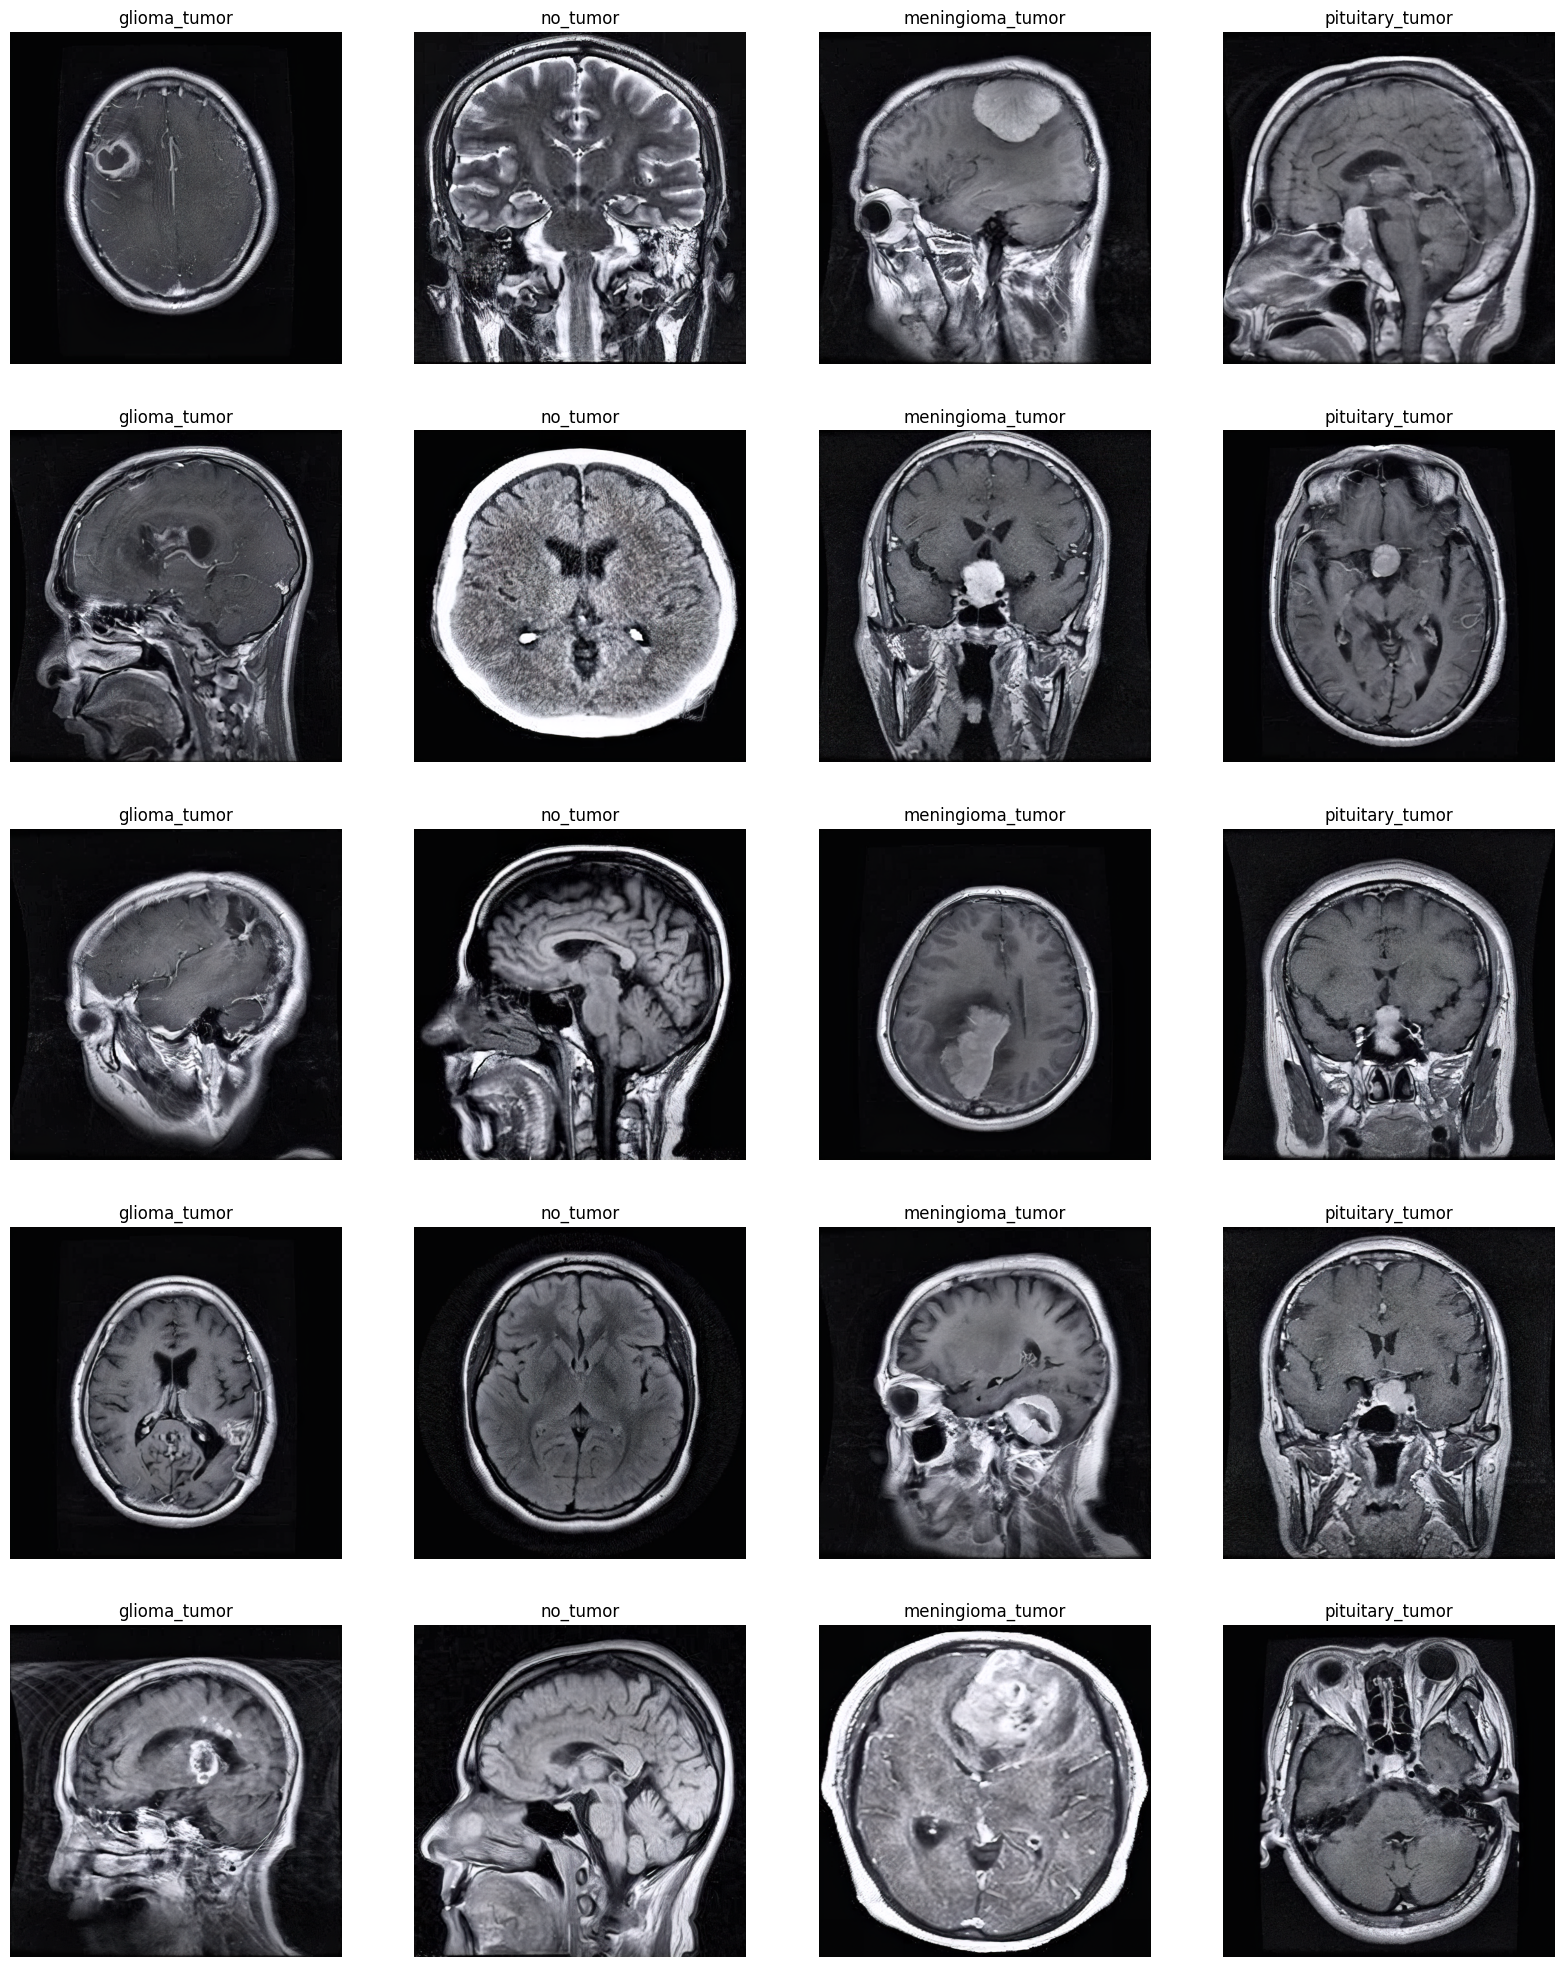

In [66]:
showImg(X_train_enhanced, Y_train, labels, num=5)

## 4. Image Storage

![https://unsplash.com/photos/purple-shutter-doors-ZVkDLrXGMdw](expalin_Images/red_storage.jpg)

### 4.1 Storing Enhanced Images

In [69]:
def save_image(img_array, label, idx, directory):
    '''
    This function save images in specified directory. 
    
    Parameters:
    - img_array: An image belonging to an specific category (Training or Testing & Categories)
    - label: The label of the image
    - idx: Index that represents the position of the images in the full dataset
    - directory: The location to save the image
    
    Returns:
    None: This function does not return a value, it stores images on a given directory. 
    '''
    category_dir = os.path.join(directory, label)
    if not os.path.exists(category_dir):
        os.makedirs(category_dir)
    
    img = Image.fromarray(img_array)
    img_path = os.path.join(category_dir, f'image_{idx}.png')
    img.save(img_path)

In [70]:
# Base directory for saving enhanced images
base_dir = 'enhancedImg'
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Testing')

# Check if the base directory exists and recursively delete it
if os.path.exists(base_dir):
    shutil.rmtree(base_dir) 

# Create directory 
os.makedirs(train_dir)
os.makedirs(test_dir)

# Define the proportion of data to allocate to testing
test_proportion = 0.10

# Shuffle the indices to randomize the data split
indices = np.arange(len(X_train_enhanced))
np.random.shuffle(indices)

# Determine the split index for test data
test_size = int(len(X_train_enhanced) * test_proportion)
test_indices = indices[:test_size]
train_indices = indices[test_size:]

# Save images to the appropriate training or testing directories
for i in train_indices:
    img_array, label = X_train_enhanced[i], Y_train[i]
    save_image(img_array, label, i, train_dir)

for i in test_indices:
    img_array, label = X_train_enhanced[i], Y_train[i]
    save_image(img_array, label, i, test_dir)

## 5. Model Setup
### 5.1 Loading and Modifying Pre-trained Models for Image Classification

**Inception V3**
- The [InceptionV3](https://pytorch.org/vision/main/models/inception.html) model is based on the [Rethinking the Inception Architecture for Computer Vision Paper](https://arxiv.org/abs/1512.00567).
- The model builder internally rely on the torchvision.models.inception.Inception3 base class. Please refer to the [Source Code](https://github.com/pytorch/vision/blob/main/torchvision/models/inception.py) for more details about this class.
    
![https://unsplash.com/photos/assorted-color-and-pattern-game-application-90qSkq4EDOc](expalin_Images/train_u_brain.jpg)

In [ ]:
class InceptionV3(nn.Module):
    '''
    A modified version of the Inception V3 model from PyTorch used for classification of 
    images (MRIs of the Brain). It takes advantages of the pre-trained weights from the 
    imageNet of 1000 classes. This architecture has been modified to classified a different
    number of classes. 
    
    Parameters:
    - num_classes: The number of classes for the classifer to output. Defaults to 4, which 
    means the model will be fine-tuned to classify inputs into one of 4 categories.
    '''
    def __init__(self, num_classes=4):
        super(InceptionV3, self).__init__()
        
        weights = torchvision.models.Inception_V3_Weights.IMAGENET1K_V1
        self.inception = torchvision.models.inception_v3(weights=weights, aux_logits=True)

        self.inception.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.LazyLinear(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        ) 
        
        self.inception.AuxLogits.fc = nn.Linear(768, num_classes)

    def forward(self, x):
        x = self.inception(x)
        return x
    
# model = InceptionV3()
# print(model.inception.fc)

## 6. Training Infrastructure
### 6.1 Defining Evaluation Functions

![https://unsplash.com/photos/orange-carrot-on-blue-surface-Z5ViTNhtPRs](expalin_Images/meaure_carrot.jpg)

In [192]:
def plot_metrics(training_losses, training_accuracies, testing_accuracies):
    '''
    This function plots the training loss and both training and testing accuracies against the
    total number of epochs (For every epoch)
    
    Parameters:
    - training_losses: liss containing all the training losses
    - training_accuracies: list containing all the trianing accuracies
    - testing_accuracies: list containing all the testing accuracies
    
    Returns:
    - None: it makes two plots one for the loss values and the other one for the accuracies
    '''
    epochs = range(1, len(training_losses) + 1)
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_losses, label='Training Loss')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_accuracies, label='Training Accuracy', marker='o')
    plt.plot(epochs, testing_accuracies, label='Testing Accuracy', marker='x')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [189]:
def evaluate_model(model, loader):
    '''
    This function evaluates the performance of models by measuring the accuracy.
    
    Parameters:
    - model: the model that we are measuring 
    - loader: the loader of the data that we are going to use to measure the performance of model. 
    
    Returns:
    - accuracy: the accuracy of the model on the given dataset
    
    Note: Since the model might return outputs in a custom structure (like InceptionOutputs), you need to 
    correctly extract the logits for accuracy calculation. This structure might include both main and 
    auxiliary outputs, but for accuracy, you only consider the main logits.
    
    During testing and real-world application, the auxiliary outputs are typically ignored, and predictions 
    are solely based on the main classifier. 

    '''
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)  
            labels = labels.to(device)
            
            outputs = model(images)
            
            # If the model outputs logits directly, use outputs; if using InceptionOutputs, access .logits
            if isinstance(outputs, torch.Tensor):
                predictions = outputs
            else:  # Assuming outputs could be an instance of InceptionOutputs or similar
                predictions = outputs.logits # main logits
            
            _, predicted = torch.max(predictions, 1)  # Get the index of the max log-probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()  # Sum up correct predictions

    accuracy = 100 * correct / total if total > 0 else 0  # Calculate accuracy
    return accuracy

# evaluate_model(model, test_loader)


In [193]:
def CNN_report(model, loader):
    '''
    This function makes generates a classification report and it also plots a confussion matrix
    
    Parameters:
    - model: the model that we want to measure its performance
    - loader: the data loader for the dataset that we want to use to measure the performance
    
    Returns:
    - None: it prints out a classification report and it plots a confusion matrix
    
    Note: Since the model might return outputs in a custom structure (like InceptionOutputs), you need to 
    correctly extract the logits for accuracy calculation. This structure might include both main and 
    auxiliary outputs, but for accuracy, you only consider the main logits.
    
    During testing and real-world application, the auxiliary outputs are typically ignored, and predictions 
    are solely based on the main classifier. 
    '''
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            if isinstance(outputs, torch.Tensor):
                logits = outputs
            else:
                logits = outputs.logits

            _, predicted = torch.max(logits, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate and print classification report
    report = classification_report(all_labels, all_predictions)
    print(report)
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


### 6.2 Defining Training Functions

![https://www.instagram.com/cbum?utm_source=ig_web_button_share_sheet&igsh=ZDNlZDc0MzIxNw==](expalin_Images/cbum_1.jpg)

#### 6.2.1 Freezing Layers Inception 3

The following is an extraction of the original architecture of the **Inception3** Module, specifically the layers closer to the output of the model. The idea behind fine-tuning only the layers closer to the output is grounded in how neural networks typically learn features
- **Lower layers** learn more general features (like edges and textures in the case of images), which are broadly useful across different tasks.
- **Higher layers (closer to the output)** learn more specific features that are more closely related to the specific tasks (like shapes specific to a category of objects in images).

By fine-tuning only the top layers, we are adapting the model to specialize to the new data while keeping the learned general features intact

**Freeze the Lower Layers:** We can "freeze" the weights of the earlier layers, so they do not update during training. This can be done by setting the ```requires_grad``` attribute to ```False``` for the parameters of those layers.

**Training Speed**: By focusing on updating only the top layers, we can reduce computational requirements and speed up the training process.

```python
class Inception3(nn.Module):
    def _forward(self, x: Tensor) -> Tuple[Tensor, Optional[Tensor]]:
```
---
```python
      if self.training:
                aux = self.AuxLogits(x)
        # N x 768 x 17 x 17
        x = self.Mixed_7a(x)
        # N x 1280 x 8 x 8
        x = self.Mixed_7b(x)
        # N x 2048 x 8 x 8
        x = self.Mixed_7c(x)
        # N x 2048 x 8 x 8
        # Adaptive average pooling
        x = self.avgpool(x)
        # N x 2048 x 1 x 1
        x = self.dropout(x)
        # N x 2048 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 2048
        x = self.fc(x)
        # N x 1000 (num_classes)
        return x, aux
```

#### Phased Unfreezing of Layers in a Pre-Trained Model for Incremental Training
For this project, we initially froze all layers of the pre-trained model. As the training progresses, we selectively unfreeze layers according to each phase and initialize the optimizer, which is then used to update the weights and biases of the specifically unfrozen layers.

In the first phase of training, we unfroze the 'fc' layer, which is the output layer. During the second phase, we unfroze the 'Mixed_7c' layer. This was followed by the unfreezing of the 'Mixed_7b' layer in the third phase, and finally, the 'Mixed_7a' layer was unfrozen in the fourth and final phase.

In [210]:
def unfreeze_model_layers(phase, model, lear_rate=0.001):
    """
    This function unfreezes layers based on the training phase and initialize the optimizer
    which it will later be used to update the weights and biased for specific unfrozen set 
    of layers based on the phase of the training. 
    
    Parameters: 
    - phase: number of phases. 
    - model: the model that we want to frezze the layers. 
    - lear_rate: The learning rate of the optimzer.
    
    Returns:
    - optimizer to update the weights and biased for an specific unfrozen set of layers
    """
    # Example logic for unfreezing: Let's say model.features is a block of layers
    if phase >= 1:
        for param in model.inception.fc.parameters():
            param.requires_grad = True
    if phase >= 2:
        for param in model.inception.Mixed_7c.parameters():
            param.requires_grad = True
    if phase >= 3:
        for param in model.inception.Mixed_7b.parameters():
            param.requires_grad = True
    if phase >= 4:
        for param in model.inception.Mixed_7a.parameters():
            param.requires_grad = True

    # Update the optimizer for the newly unfrozen parameters
    return optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lear_rate)



In [211]:
def train_model(model, criterion, num_epochs=25, num_phases=4, num_classes=4):
    '''
    This function is used to train the model in a given set of epochs and phases. Every phase 
    of the training unlocks or defroze a set of layers to be updated during the training. It also
    conduct some basic performance metrics such as the accuracy of train and test and training loss.
    This function also updates the learning rate (make it smaller) of the optimizer as the training 
    progress.
    
    Note: to calculate the total number of epochs on the training (epochs * phase) 
    - for example: epochs=25 and phases=4 then total number of epochs is 25 * 4 = 100
    
    Parameters:
    - model: the model that we want to train
    - criterion: the loss function 
    - num_epochs: number of epochs of each phases 
    - num_phases: number of phases
    - num_classes: number of categories (labels)
    
    Returns:
    - All the training losses and both the training and testing accuracy. 
    '''
    model.to(device)
    all_training_losses = []
    all_training_accuracies = []
    all_testing_accuracies = []
    lear_rate = [0.001, 0.0001, 0.00001, 0.00001]
    
    for phase in range(1, num_phases + 1):
        num_lr = phase - 1
        optimizer = unfreeze_model_layers(phase=phase, model=model, lear_rate=lear_rate[num_lr])  # Unfreeze layers gradually
        for epoch in range(num_epochs):  # Train for some epochs per phase
            running_loss = 0.0
            model.train()
            for data, labels in train_loader:
                data = data.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                outputs = model(data)
                
                main_output = outputs.logits
                aux_output = outputs.aux_logits
                
                # Calculate the main loss and auxiliary loss
                main_loss = criterion(main_output, labels)
                aux_loss = criterion(aux_output, labels) if aux_output is not None else 0

                # Combine losses: usually one of the losses is weighted lower.
                loss = main_loss + 0.4 * aux_loss  # 0.4 is weight for auxillary classifier
                
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            training_loss = running_loss/len(train_loader)
            training_acc = evaluate_model(model=model, loader=train_loader)
            test_acc = evaluate_model(model=model, loader=test_loader)
            
            all_training_losses.append(training_loss)
            all_training_accuracies.append(training_acc)
            all_testing_accuracies.append(test_acc)
            
            if (epoch + 1) % 5 == 0:
                print(f"Phase {phase}, Epoch {epoch+1}, Training Loss: {training_loss}, Train Accuracy: {training_acc:.2f}%, Test Accuracy: {test_acc:.2f}%")
        
    return all_training_losses, all_training_accuracies, all_testing_accuracies

## 7. Model Training and Evaluation with Enhanced Images
### 7.1 Training the Model & Evaluating Model Performance

In [212]:
transform = transforms.Compose([
    transforms.Resize(299),  # Resize images to the input size of Inception_v3
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

base_dir = 'enhancedImg'  

train_data = datasets.ImageFolder(root=os.path.join(base_dir, 'Training'), transform=transform)
test_data = datasets.ImageFolder(root=os.path.join(base_dir, 'Testing'), transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True,
                            num_workers=4)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False,
                            num_workers=4)


In [213]:
device = torch.device("cuda")
enhanced_model = InceptionV3().to(device)

# Initially freeze all parameters
for param in enhanced_model.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = unfreeze_model_layers(phase=1, model=enhanced_model)  # Start training phase 1

Phase 1, Epoch 5, Training Loss: 1.3371345473498832, Train Accuracy: 83.43%, Test Accuracy: 80.84%
Phase 1, Epoch 10, Training Loss: 1.2972036425660296, Train Accuracy: 81.48%, Test Accuracy: 77.35%
Phase 1, Epoch 15, Training Loss: 1.2534807324409485, Train Accuracy: 84.69%, Test Accuracy: 80.84%
Phase 1, Epoch 20, Training Loss: 1.2402997016906738, Train Accuracy: 86.38%, Test Accuracy: 81.88%
Phase 1, Epoch 25, Training Loss: 1.2139153538680658, Train Accuracy: 86.15%, Test Accuracy: 81.53%
Phase 2, Epoch 5, Training Loss: 0.6670991240478144, Train Accuracy: 99.66%, Test Accuracy: 87.11%
Phase 2, Epoch 10, Training Loss: 0.5938955610845147, Train Accuracy: 100.00%, Test Accuracy: 87.46%
Phase 2, Epoch 15, Training Loss: 0.5866718815594185, Train Accuracy: 100.00%, Test Accuracy: 87.80%
Phase 2, Epoch 20, Training Loss: 0.6008525454416508, Train Accuracy: 100.00%, Test Accuracy: 89.55%
Phase 2, Epoch 25, Training Loss: 0.5867992465089007, Train Accuracy: 100.00%, Test Accuracy: 89.90

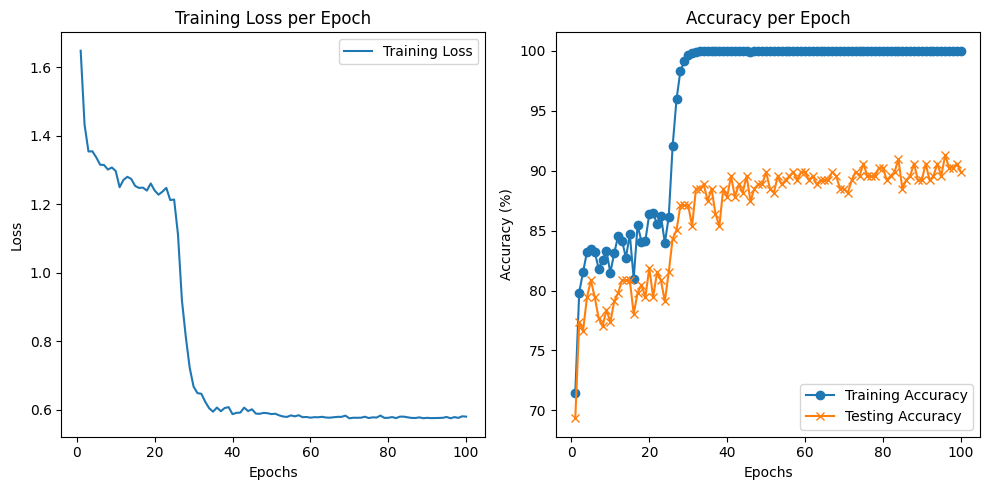

In [214]:
training_losses, training_accuracies, testing_accuracies = train_model(enhanced_model, 
                                                                       criterion, 
                                                                       num_epochs=25, 
                                                                       num_phases=4, 
                                                                       num_classes=4)

plot_metrics(training_losses, training_accuracies, testing_accuracies)

              precision    recall  f1-score   support

           0       0.96      0.78      0.86        88
           1       0.85      0.89      0.87        76
           2       0.74      0.92      0.82        25
           3       0.94      1.00      0.97        98

    accuracy                           0.90       287
   macro avg       0.87      0.90      0.88       287
weighted avg       0.91      0.90      0.90       287



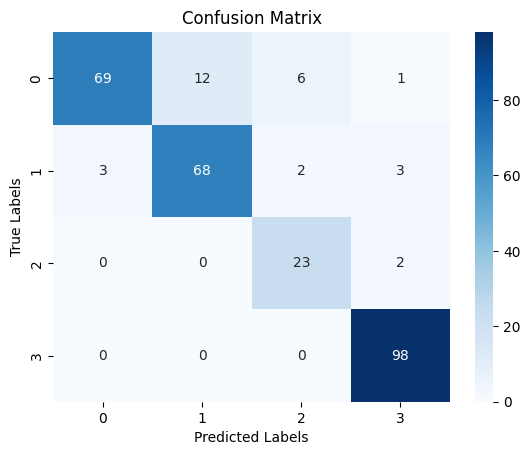

In [215]:
CNN_report(enhanced_model, test_loader)

### 7.2 Enhanced Image Model Performance

Based on the results gathered from the highest-rated Kaggle notebooks within the data science community on Kaggle, the accuracy rates typically range from 30% to 70%. However, our model, which utilizes enhanced images, achieved an accuracy of 90%.

The Classification Report indicates that our model demonstrates high precision when predicting Classes 0 and 3, suggesting that predictions made by our model for these classes are usually accurate. 
- This observation is supported by the Confusion Matrix, which shows that the model misclassifies true instances of Class 0 as Class 1, and similarly, misclassifications involving Class 3 are infrequent. 
- Although the precision for Classes 1 and 2 is lower compared to Classes 0 and 3, the results for these classes are still reasonably good.

Class 0 shows a low recall compared to the other classes, indicating that the model frequently overlooks actual instances of Class 0. Consequently, many instances of Class 0 are likely misidentified as belonging to other classes, resulting in a substantial number of false negatives for Class 0.

## 8. Model Training and Evaluation with Original Images
### 8.1 Training the Model & Evaluating Model Performance

In [216]:
transform = transforms.Compose([
    transforms.Resize(299),  # Resize images to the input size of Inception_v3
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to ignore files starting with .
def is_valid_file(x):
    return not os.path.basename(x).startswith('.')

base_dir = 'data'  

train_data = datasets.ImageFolder(root=os.path.join(base_dir, 'Training'), transform=transform, is_valid_file=is_valid_file)
test_data = datasets.ImageFolder(root=os.path.join(base_dir, 'Testing'), transform=transform, is_valid_file=is_valid_file)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True,
                            num_workers=0)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False,
                            num_workers=0)

In [218]:
device = torch.device("cuda")
original_model = InceptionV3().to(device)

# Initially freeze all parameters
for param in original_model.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()

optimizer = unfreeze_model_layers(phase=1, model=original_model)  # Start training phase 1

C:\Users\elian\OneDrive\Documents\NJIT\njit\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Phase 1, Epoch 5, Training Loss: 1.353771001762814, Train Accuracy: 86.45%, Test Accuracy: 56.59%
Phase 1, Epoch 10, Training Loss: 1.2720444162686666, Train Accuracy: 87.60%, Test Accuracy: 61.15%
Phase 1, Epoch 15, Training Loss: 1.2552836848629845, Train Accuracy: 81.94%, Test Accuracy: 55.16%
Phase 1, Epoch 20, Training Loss: 1.2170838442113665, Train Accuracy: 89.61%, Test Accuracy: 55.64%
Phase 1, Epoch 25, Training Loss: 1.1929651790195042, Train Accuracy: 89.79%, Test Accuracy: 62.11%
Phase 2, Epoch 5, Training Loss: 0.7354194727208879, Train Accuracy: 99.83%, Test Accuracy: 71.94%
Phase 2, Epoch 10, Training Loss: 0.6800018774138556, Train Accuracy: 100.00%, Test Accuracy: 74.82%
Phase 2, Epoch 15, Training Loss: 0.6769958138465881, Train Accuracy: 100.00%, Test Accuracy: 71.70%
Phase 2, Epoch 20, Training Loss: 0.6744382560253144, Train Accuracy: 100.00%, Test Accuracy: 73.86%
Phase 2, Epoch 25, Training Loss: 0.6650197088718415, Train Accuracy: 100.00%, Test Accuracy: 72.66%

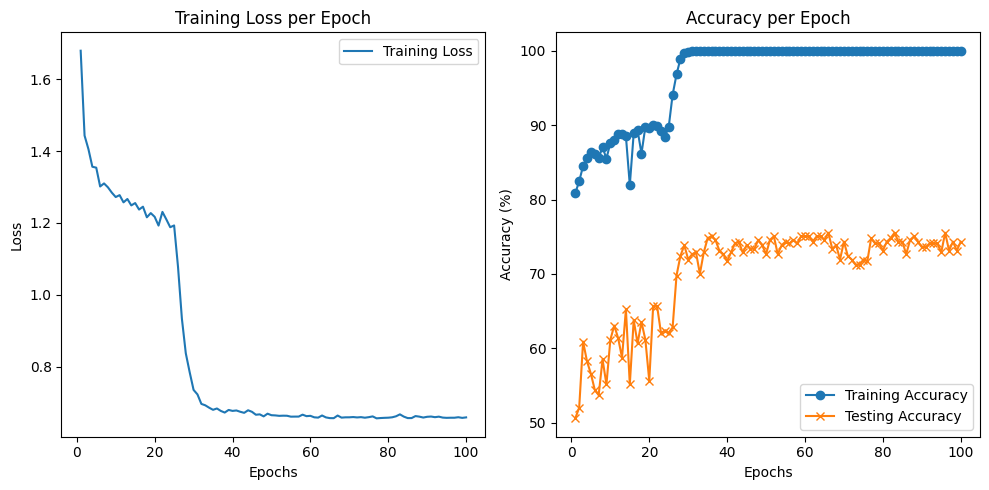

In [219]:
# Train the model
training_losses, training_accuracies, testing_accuracies = train_model(original_model, 
                                                                       criterion, 
                                                                       num_epochs=25, 
                                                                       num_phases=4, 
                                                                       num_classes=4)

# Plot the results
plot_metrics(training_losses, training_accuracies, testing_accuracies)

              precision    recall  f1-score   support

           0       1.00      0.24      0.39       123
           1       0.73      1.00      0.84       115
           2       0.62      1.00      0.77       105
           3       1.00      0.81      0.90        74

    accuracy                           0.74       417
   macro avg       0.84      0.76      0.72       417
weighted avg       0.83      0.74      0.70       417



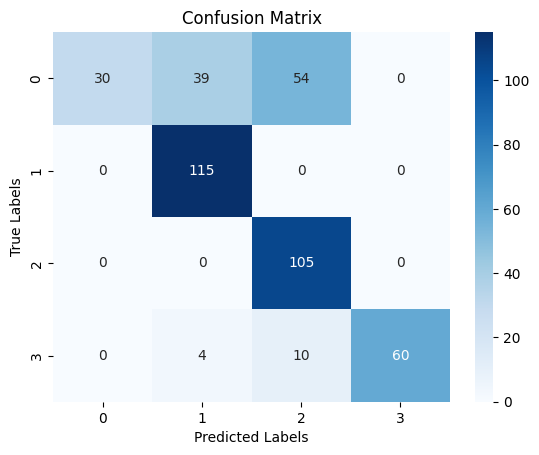

In [220]:
CNN_report(original_model, test_loader)

### 8.2 Original Image Model Performance

Based on the results gathered from the highest-rated Kaggle notebooks within the data science community on Kaggle, the accuracy rates typically range from 30% to 70%. However, our model, which utilizes original images, achieved an accuracy of 74% which is very low compare to our model trained with enhanced images but it is still pretty good compared to the results from the highest-rated Kaggle notebooks.

The Classification Report indicates that our model demonstrates a perfect precision when predicting Classes 0 and 3, suggesting that predictions made by our model for these classes are very accurate. 
- This observation is supported by the Confusion Matrix, which shows that the model does not missclassified instances from these two labels. 
- Although the precision for Classes 1 and 2 is very low compared to Classes 0 and 3, the results for these classes are still reasonably good.
    - Class 1 is being classified as Class 0 by the model and 
    - Class 2 is usually classified as class 0 by the model. 

Class 0 shows a very low recall compared to the other classes, indicating that the model frequently overlooks actual instances of Class 0. Consequently, many instances of Class 0 are likely misidentified as belonging to other classes, resulting in a substantial number of false negatives for Class 0.

## 9. References

![https://unsplash.com/photos/brown-wooden-book-shelves-in-library-yEQ9TOaL5FM](expalin_Images/references.jpg)

### 9.1 Articles & Online Resources

- Xintao Wang, Liangbin Xie, Ke Yu, Kelvin C.K. Chan, Chen Change Loy and Chao Dong. BasicSR: Open Source Image and Video Restoration Toolbox. https://github.com/xinntao/BasicSR, 2022.
    - https://github.com/XPixelGroup/BasicSR
    
- Pixel Perfect: ESRGAN-powered High-Resolution Image Upscaling Platform: https://medium.com/aiskunks/pixel-perfect-esrgan-powered-high-resolution-image-upscaling-platform-2c3ae0934d53

- Inception V3 CNN Architecture Explained: https://medium.com/@AnasBrital98/inception-v3-cnn-architecture-explained-691cfb7bba08
    
- Pytorch Inception V3 models: https://pytorch.org/vision/main/models/inception.html
    - Rethinking the Inception Architecture for Computer Vision paper: https://arxiv.org/abs/1512.00567
    - Soruce Code: https://github.com/pytorch/vision/blob/main/torchvision/models/inception.py

- Implementation of the "Accelerating the Super-Resolution Convolutional Neural Network": https://github.com/yjn870/FSRCNN-pytorch

- PyTorch Tutorial to Super-Resolution for learning about GANs: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Super-Resolution/tree/master

- Library for Minimal Modern Image Super-Resolution in PyTorch: https://github.com/isaaccorley/pytorch-enhance

- Exporting a Model from PyTorch to ONNX and Running it using ONNX Runtime: https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html?highlight=onnx

- Super Resolution with ESRGAN: https://mpolinowski.github.io/docs/IoT-and-Machine-Learning/ML/2022-04-02-pytorch-super-resolution/2022-04-02/

- How the pytorch freeze network in some layers, only the rest of the training?: https://discuss.pytorch.org/t/how-the-pytorch-freeze-network-in-some-layers-only-the-rest-of-the-training/7088/23
    - Freeze certain layers of an existing model in PyTorch: https://stackoverflow.com/questions/62523912/freeze-certain-layers-of-an-existing-model-in-pytorch
    
- How to optimize inception model with auxiliary classifiers: https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958

- MapExtrakt: https://github.com/arched-dev/mapextrackt

- Free Images from Unsplash: https://unsplash.com/

- Chris Bumstead Classic Physique Mr. Olympia x5🇨🇦: https://www.instagram.com/cbum/

- Scikit-Learn: https://scikit-learn.org/stable/
    - Confussion Matrix: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
        - https://en.wikipedia.org/wiki/Confusion_matrix
    - Classification report:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

---
**Kaggle Notebooks Targeting the Brain Tumor Classification (MRI)**:
- Brain Tumor Detection- Keras/Pytorch: https://www.kaggle.com/code/fahadmehfoooz/brain-tumor-detection-keras-pytorch
- Brain Tumor Classification with custom CNN: https://www.kaggle.com/code/alsaniipe/brain-tumor-classification-with-custom-cnn
- Brain Tumor: https://www.kaggle.com/code/shivamagarwal29/brain-tumor
- Tumor Classification: https://www.kaggle.com/code/rohandeysarkar/tumor-classification
- Brain Tumor detection using CNN: https://www.kaggle.com/code/vishweshsalodkar/brain-tumor-detection-using-cnn
- Tumar classification VGG19, ResNet101,Xception, Mo: https://www.kaggle.com/code/mostafizur1997/tumar-classification-vgg19-resnet101-xception-mo
- Brain Tumor Classification And Prediction/FULL EXP: https://www.kaggle.com/code/brsdincer/brain-tumor-classification-and-prediction-full-exp

## 10. Cemetery
### 10.1 Unused Code

![https://unsplash.com/photos/brown-wooden-book-shelves-in-library-yEQ9TOaL5FM](expalin_Images/skull.jpg)

In [ ]:
# Save each image in the directory corresponding to its label
# for i, (img_array, label) in enumerate(zip(X_train_enhanced, Y_train)):
#     # Create a directory for the category if it doesn't exist
#     category_dir = os.path.join(base_dir, label)
#     if not os.path.exists(category_dir):
#         os.makedirs(category_dir)

#     # Convert the numpy array back to an image
#     img = Image.fromarray(img_array)
#     # Create a file path
#     img_path = os.path.join(category_dir, f'image_{i}.png')
#     # Save the image
#     img.save(img_path)

In [ ]:
# for X, y in train_loader:
#         print(X.shape, X.dtype, y.shape, y.dtype)
#         print(y)
#         break

In [ ]:
# weights = torchvision.models.Inception_V3_Weights.IMAGENET1K_V1
# inception = torchvision.models.inception_v3(weights=weights)
# # print(inception)

In [ ]:
# print(inception.fc.parameters())
# print(model.inception.parameters())
# print(inception.Conv2d_1a_3x3.parameters)
# print(model.parameters)
# print(model.fc.parameters())
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# for X, y in train_loader:
#     print(X.shape, X.dtype, y.shape, y.dtype)
#     print(y)
#     break

In [ ]:
# timer = d2l.Timer()
# for X, y in train_loader:
#     continue
# f'{timer.stop():.2f} sec'

In [13]:
# Base directory for saving original images
# base_dir = 'oldImg'

# # Check if the base directory exists and recursively delete it
# if os.path.exists(base_dir):
#     shutil.rmtree(base_dir) 

# # Create the base directory 
# os.makedirs(base_dir)

# # Save each image in the directory corresponding to its label
# for i, (img_array, label) in enumerate(zip(X_train[0:100], Y_train[0:100])):
#     # Create a directory for the category if it doesn't exist
#     category_dir = os.path.join(base_dir, label)
#     if not os.path.exists(category_dir):
#         os.makedirs(category_dir)

#     # Convert the numpy array back to an image
#     img = Image.fromarray(img_array)
#     # Create a file path
#     img_path = os.path.join(category_dir, f'image_{i}.png')
#     # Save the image
#     img.save(img_path)

In [ ]:
# # Specify the directory to save images
# save_dir = 'enhancedImg'
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)

# # Save each image in the directory
# for i, img_array in enumerate(X_train_enhanced):
#     # Convert the numpy array back to an image
#     img = Image.fromarray(img_array.astype('uint8'))  # Ensure data type is uint8 for image
#     # Create a file path
#     img_path = os.path.join(save_dir, f'image_{i}.png')
#     # Save the image
#     img.save(img_path)

# print("All images have been saved.")